In [1]:
import numpy as np
import pandas as pd 

In [2]:
df = pd.read_csv('C:/Users/Kazem Kamrani/Desktop/Time Series Analysis/international-airline-passengers.csv',
                 index_col = 'Month',
                 parse_dates = True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.isna().sum()

Passengers    0
dtype: int64

<AxesSubplot:xlabel='Month'>

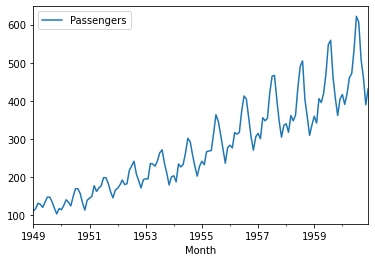

In [5]:
df.plot()

In [6]:
alpha = 0.2

In [7]:
df['EWMA']=df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [8]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False).mean())

pandas.core.series.Series

<AxesSubplot:xlabel='Month'>

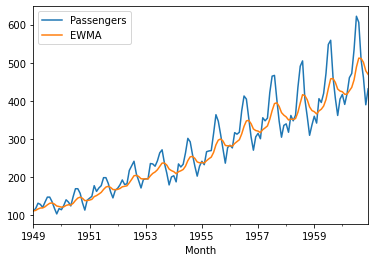

In [9]:
df.plot()

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [11]:
ses = SimpleExpSmoothing(df['Passengers'])

C:\Users\Kazem Kamrani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [13]:
df.index.freq = 'MS'

In [14]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method = 'legacy-heuristic')

In [15]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [16]:
res

In [17]:
df['SES']=res.predict(start=df.index[0], end=df.index[-1])

In [18]:
np.allclose(df['SES'],res.fittedvalues)

True

<AxesSubplot:xlabel='Month'>

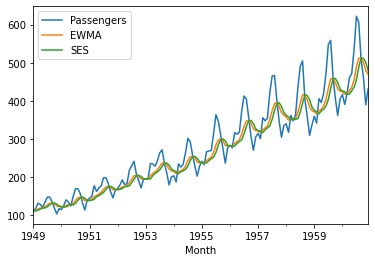

In [19]:
df.plot()

In [20]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [21]:
df['SES-1'] = df['SES'].shift(-1)

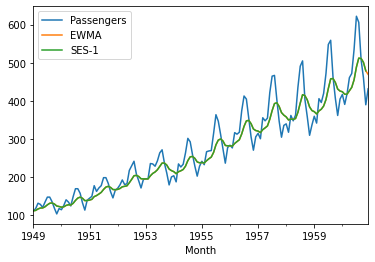

In [22]:
### No!
df[['Passengers','EWMA','SES-1']].plot();

In [23]:
N_test = 12 
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [24]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [25]:
#boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

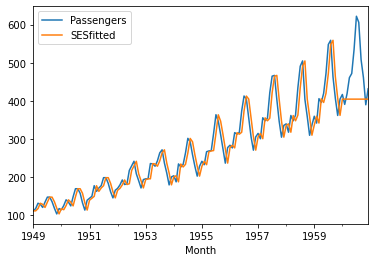

In [26]:
df.loc[train_idx,'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot();

In [27]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [28]:
from statsmodels.tsa.holtwinters import Holt

In [29]:
holt = Holt(
     df['Passengers'],
     initialization_method = 'legacy-heuristic')

In [30]:
res_h = holt.fit()

In [31]:
df['Holt'] = res_h.fittedvalues

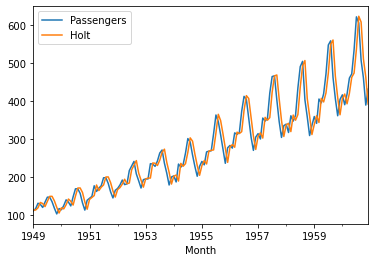

In [32]:
df [['Passengers','Holt']].plot();

<AxesSubplot:xlabel='Month'>

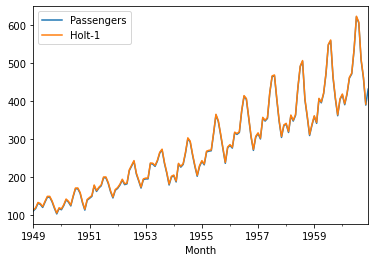

In [33]:
### No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers','Holt-1']].plot()

In [34]:
holt = Holt(train['Passengers'], initialization_method = 'legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx,'Holt'] = res_h.fittedvalues

In [35]:
df.loc[test_idx,'Holt'] = res_h.forecast(N_test)

<AxesSubplot:xlabel='Month'>

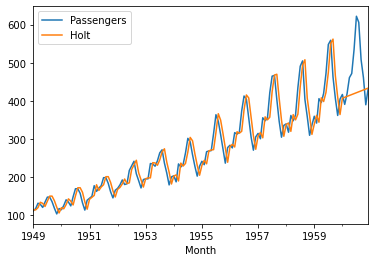

In [36]:
df[['Passengers','Holt']].plot()

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [38]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal ='add',seasonal_periods=12)
res_hw = hw.fit()

In [39]:
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues

In [40]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

<AxesSubplot:xlabel='Month'>

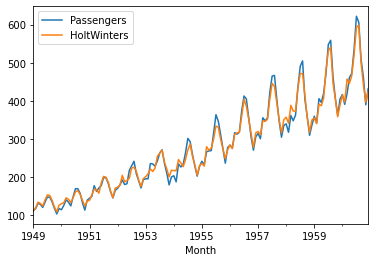

In [41]:
df[['Passengers','HoltWinters']].plot()

In [42]:
from sklearn import metrics
#Train
print('R2 Score is: ', metrics.explained_variance_score(train['Passengers'], res_hw.fittedvalues))
print('Mean Squared Error is: ', metrics.mean_squared_error(train['Passengers'], res_hw.fittedvalues))
print('Root Mean Squared Error is: ', np.sqrt(metrics.mean_squared_error(train['Passengers'], res_hw.fittedvalues)))
print('Mean Absolute Error is: ', metrics.mean_absolute_error(train['Passengers'], res_hw.fittedvalues))
print('Mean Absolute Percentage Error is: ', metrics.mean_absolute_percentage_error(train['Passengers'], res_hw.fittedvalues))

R2 Score is:  0.9880231805362072
Mean Squared Error is:  135.13363945628797
Root Mean Squared Error is:  11.62469954262423
Mean Absolute Error is:  9.011203838180057
Mean Absolute Percentage Error is:  0.03576642048704757


In [43]:
# Test
print('R2 Score is: ', metrics.explained_variance_score(test['Passengers'], res_hw.forecast(N_test)))
print('Mean Squared Error is: ', metrics.mean_squared_error(test['Passengers'], res_hw.forecast(N_test)))
print('Root Mean Squared Error is: ', np.sqrt(metrics.mean_squared_error(test['Passengers'], res_hw.forecast(N_test))))
print('Mean Absolute Error is: ', metrics.mean_absolute_error(test['Passengers'], res_hw.forecast(N_test)))
print('Mean Absolute Percentage Error is: ', metrics.mean_absolute_percentage_error(test['Passengers'], res_hw.forecast(N_test)))

R2 Score is:  0.952228385386693
Mean Squared Error is:  288.3591705657535
Root Mean Squared Error is:  16.98114161550258
Mean Absolute Error is:  13.382207171715427
Mean Absolute Percentage Error is:  0.028031445691352772


<AxesSubplot:xlabel='Month'>

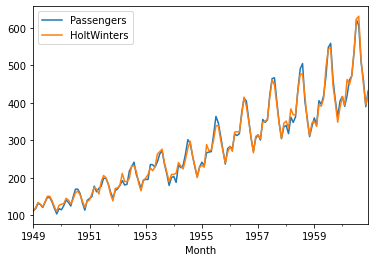

In [44]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal ='mul',seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot()

In [45]:
print('Train Root Mean Squared Error is: ', np.sqrt(metrics.mean_squared_error(train['Passengers'], res_hw.fittedvalues)))
print('Test Root Mean Squared Error is: ', np.sqrt(metrics.mean_squared_error(test['Passengers'], res_hw.forecast(N_test))))
print('Train Mean Absolute Error is: ', metrics.mean_absolute_error(train['Passengers'], res_hw.fittedvalues))
print('Test Mean Absolute Error is: ', metrics.mean_absolute_error(test['Passengers'], res_hw.forecast(N_test)))

Train Root Mean Squared Error is:  9.768020481856626
Test Root Mean Squared Error is:  15.809890178532703
Train Mean Absolute Error is:  7.604221246063915
Test Mean Absolute Error is:  10.302594878699557


C:\Users\Kazem Kamrani\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot:xlabel='Month'>

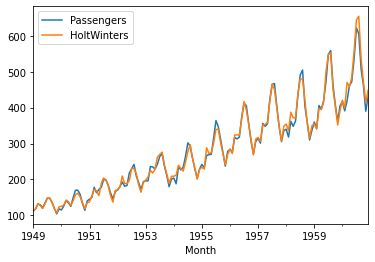

In [46]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal ='mul',seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot()

In [47]:
print('Train Root Mean Squared Error is: ', np.sqrt(metrics.mean_squared_error(train['Passengers'], res_hw.fittedvalues)))
print('Test Root Mean Squared Error is: ', np.sqrt(metrics.mean_squared_error(test['Passengers'], res_hw.forecast(N_test))))
print('Train Mean Absolute Error is: ', metrics.mean_absolute_error(train['Passengers'], res_hw.fittedvalues))
print('Test Mean Absolute Error is: ', metrics.mean_absolute_error(test['Passengers'], res_hw.forecast(N_test)))

Train Root Mean Squared Error is:  9.617924831716339
Test Root Mean Squared Error is:  25.81135901063159
Train Mean Absolute Error is:  7.11238634958478
Test Mean Absolute Error is:  20.84917774687902
